In [1]:
#imports
import numpy as np
from skimage.measure import label, regionprops
from skimage.draw import line, set_color
import imageio
import cv2
import operator
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from tqdm import tqdm_notebook
from PIL import Image
import argparse
from tqdm import tqdm
# from Tkinter import *

# Homography for Novel Objects and Animal Speed Estimation

In [2]:
#Find homography
source_pts = np.array([[100, 90], [475, 70], [425, 370], [75, 470]], dtype = 'float32') #pixels!
dst_pts = np.array([[0, 0], [100, 0], [80, 80], [0, 100]], dtype = 'float32') #cm

homography_matrix, _ = cv2.findHomography(source_pts, dst_pts, cv2.RANSAC, 5.0) #not sure what the 5.0 is really doing seems to work though
POINTMOO = np.array([[75,470]],dtype = 'float32')
POINTMOO = np.array([POINTMOO])
dst_pt = cv2.perspectiveTransform(POINTMOO, homography_matrix)
#print(dst_pt[0][0][0])
#print(dst_pt[0][0][1])
#print(dst_pt)

In [3]:
#Locations of objects and distance thresholds (how close does the rat have to be to be near it)
familiarObject_center_x = 380
familiarObject_center_y = 160
realWorld_famObj_center = cv2.perspectiveTransform(np.array([np.array([[familiarObject_center_x,familiarObject_center_y]], dtype='float32')]), homography_matrix)
familiarObject_center_x_realWorld = realWorld_famObj_center[0][0][0]
familiarObject_center_y_realWorld = realWorld_famObj_center[0][0][1]
DistanceThreshold_familiarObject = 22; #cm
numFrames_FamiliarObject = 0;

novelObject_center_x = 210
novelObject_center_y = 320
realWorld_novelObj_center = cv2.perspectiveTransform(np.array([np.array([[novelObject_center_x,novelObject_center_y]],dtype='float32')]), homography_matrix)
novelObject_center_x_realWorld = realWorld_novelObj_center[0][0][0]
novelObject_center_y_realWorld = realWorld_novelObj_center[0][0][1]
DistanceThrehshold_NovelObject = 22; #cm
numFrames_NovelObject = 0;

In [4]:
DistanceThrehshold_NovelObject = 15 #cm
DistanceThreshold_familiarObject = 15 

# Video Tracking File Name!

In [5]:
filename = '/home/shayok/Documents/NovelObject/Remi/Round2/Day3/Test-2-cropped.mkv'

# Actual Work Happens Below
## Initialize stuff

In [6]:
#setup for background model and foreground tracking
if 'fgbg' not in locals():
    fgbg = cv2.createBackgroundSubtractorKNN()
    
morph_size = 2
shadowValue = 127
learnBG = False
showShadow = False

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))

## Just use this to train the background

<div class = "alert alert-danger">
<b> ARIEL:</b> Remove the centroid tracking from this and displaying the fgmask and saving the video, please. Thank you! I'd do it myself but it's more fun to write things in red bold letters. This will make things a little faster but honestly this entire thing needs to be faster and parallelized as much as possible (discuss sometime).
</div>

input video file length is 697.2333333333333 seconds
input video file has a framerate of 30.0 fps
background learning ON
background learning OFF
shadows ON
shadows OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
background learning ON
background learning OFF
Total amount of time spent with objects: 27.766666666666666 seconds
Percentage of time spent with objects that was spent with the novel object: 91.35654261704681%
exited gracefully


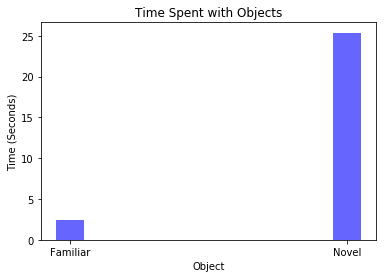

In [7]:
#File IO
numFrames_FamiliarObject = 0
numFrames_NovelObject = 0
reader = imageio.get_reader(filename)
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

#Read in file frame by frame. Perform position tracking background subtraction
# cv2.morph_open
centers=[]
for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)
    
    region_areas = []
    
    for props in regions:
        region_areas.append(props.area)
    
    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))
    
        ratBlob = regions[largestBlobIndex]
        
        #print(ratBlob.perimeter)
        #ratContours = find_contours(fgmask,0.8)
        #print(ratContours)
        #ratContours = np.asarray(ratContours).reshape(-1,1,2).astype(np.int32)
        #print(ratContours)
        #cv2.drawContours(im, ratContours,0,(0,255,0),2)
        #cv2.putText(im, str(ratContours[0][0]), (30,30), cv2.FONT_HERSHEY_PLAIN,2,255)
        
        y0, x0 = ratBlob.centroid
        centers.append([x0,y0])
#MOOO
        #Contour and line of best fit
#         _, contours, _ = cv2.findContours(fgmask,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#         #print(contours[0])
#         #print(ratContours)
#         rows, cols = im.shape[:2]
#         [vx,vy,x,y] = cv2.fitLine(contours[0], cv2.DIST_L2,0,0.01,0.01)
#         lefty = int((-x*vy/vx) + y)
#         righty = int(((cols-x)*vy/vx) + y)
#         cv2.drawContours(im, contours, 0,(0,255,0),2)
#         cv2.arrowedLine(im,(cols-1,righty),(0,lefty),(255,0,0),2)

        #draw tracking "dot"
        cv2.circle(im,(int(x0),int(y0)),10,(255,255,255),-11)
        cv2.circle(im,(int(x0),int(y0)),11,(0,0,255),1) # draw circle
        cv2.ellipse(im, (int(x0),int(y0)), (10,10), 0, 0, 90,(0,0,255),-1 )
        cv2.ellipse(im, (int(x0),int(y0)), (10,10), 0, 180, 270,(0,0,255),-1 )
        cv2.circle(im,(int(x0),int(y0)),1,(0,255,0),1) # draw center
        #cv2.putText(OriImage,pid,(int(cx)+10,int(cy)-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,180,180))
        
        # 'dot' location of familiar object
        cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,0,0),10) 
        
        # 'dot' location of novel object
        cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,0,0),10) 
        
        realWorldPoint = cv2.perspectiveTransform(np.array([np.array([[x0,y0]],dtype='float32')]), homography_matrix)
        realWorldX = realWorldPoint[0][0][0]
        realWorldY = realWorldPoint[0][0][1]
        
        distanceFromNovelObject = math.hypot(novelObject_center_x_realWorld - realWorldX, novelObject_center_y_realWorld - realWorldY)
        distanceFromFamiliarObject = math.hypot(familiarObject_center_x_realWorld - realWorldX, familiarObject_center_y_realWorld - realWorldY)
        if(distanceFromNovelObject < DistanceThrehshold_NovelObject):
            numFrames_NovelObject = numFrames_NovelObject + 1
            cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,255,0),10) 

        if(distanceFromFamiliarObject < DistanceThreshold_familiarObject):
            numFrames_FamiliarObject = numFrames_FamiliarObject + 1
            cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,255,0),10) 
            
        
    cv2.imshow('fgmask',fgmask)
    cv2.imshow('im',im)
    cv2.imshow('bg',bg)
    
    im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # imageio writer takes RGB

    writer.append_data(im)
    
    k = cv2.waitKey(1) & 0xff
#    if k!= 255:
#        print(k)
    if k == 32: # 'space'
        if learnBG:
            learnBG = False
            print('background learning OFF')
        else:
            learnBG = True
            print('background learning ON')
    if k == 115: # 's'
        if showShadow:
            showShadow = False
            shadowValue = 0
            print('shadows OFF')
        else:
            showShadow = True
            shadowValue = 127
            print('shadows ON')
        #fgbg.setDetectShadows(showShadow)
        fgbg.setShadowValue(shadowValue)
            
    if k == 171 or k == 43: # '+'
        if morph_size < 20:
            morph_size +=5
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 173 or k == 45: # '-'
        if morph_size > 2:
            morph_size -=1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 27:
        break
        
        
print("Total amount of time spent with objects: {} seconds".format((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps)))
print("Percentage of time spent with objects that was spent with the novel object: {}%".format((numFrames_NovelObject*100/fps)/((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps))))
writer.close()
cv2.destroyAllWindows()
print('exited gracefully')

timeSpentFamObject = numFrames_FamiliarObject/fps
timeSpentNovObject = numFrames_NovelObject/fps

timeSpent = ('Familiar', 'Novel')
n_groups = len(timeSpent)
index = np.arange(n_groups)
bar_width = 0.1

plt.bar(index, [timeSpentFamObject, timeSpentNovObject], bar_width, color='blue', align='center', alpha=0.6)

plt.title("Time Spent with Objects")
plt.xticks(index, ('Familiar', 'Novel'))
plt.xlabel("Object")
plt.ylabel("Time (Seconds)")
plt.show()

## Bifurcations
<br>
<div class="alert alert-danger">
<b>ARIEL:</b> Remove the background model display from this one please! Thank you! Once again, I could do it myself but I'm having fun writing in red letters and same as above it's irrelevant in the long run but will be faster in the short-term for you
</div>

In [ ]:

#File IO
numFrames_FamiliarObject = 0
numFrames_NovelObject = 0
reader = imageio.get_reader(filename)
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

refPt = []

# def click(event, x, y, flags, param):
#     # grab references to the global variables
#     global refPt
    
#     # if the left mouse button was clicked, record the starting
#     # (x, y) coordinates and indicate that cropping is being
#     # performed
#     if event == cv2.EVENT_LBUTTONDOWN:
#         refPt = [(x, y)]
#         posx = refPt[0]
#         posy = refPt[1]
#         return posx, posy

# click(cv2.EVENT_LBUTTONDOWN)

class Position:
    def __init__(self, m, n):
        self.coordinates = np.zeros((m, n))
        self.click = False

    def select_coordinates(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            #Set coordinates to mouse position
            self.coordinates[i, :] = [x, y]
            self.clickcoords = [x,y]
            print (self.clickcoords[0], self.clickcoords[1])
            self.click = True
position = Position(reader.get_length(), 2)
cv2.namedWindow('im', flags=cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('im', position.select_coordinates)


centers1 = {}
centers2 = {}

def dist_pts(y,x,yy,xx):
#     ht = (int(yy)-int(y))**2
#     wdth = (int(xx)-int(x))**2
#     if ht == 0:
#         dist = int(xx) - int(x)
#     elif wdth == 0:
#         dist = int(yy) - int(y)
#     else:
#         dist = math.sqrt(ht/wdth)
    dist = math.hypot(xx - x, yy - y)
    return dist

#Read in file frame by frame. Perform position tracking background subtraction

for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)
    
    region_areas = []
    
    for props in regions:
        region_areas.append(props.area)
    
    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))
        
        # Find largest object in foreground
        ratBlob = regions[largestBlobIndex]
        
        # Find center coordinates of largest foreground object
        y0, x0 = ratBlob.centroid
        cv2.circle(im,(int(x0), int(y0)),10,(255,0,0),-11)
        # Find angle between x axis and major axis of an ellipse around largest foreground object
        orient_ratBlob = ratBlob.orientation
        
        # Find coordinates of endpoints of major axis
#         x1 = x0 + math.cos(orient_ratBlob) * 0.5 * ratBlob.major_axis_length
#         y1 = y0 - math.sin(orient_ratBlob) * 0.5 * ratBlob.major_axis_length
        x2 = x0 - math.sin(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        y2 = y0 - math.cos(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        x3 = x0 + math.sin(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        y3 = y0 + math.cos(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        
        rr1, cc1 = line(int(y0), int(x0), int(y2), int(x2))
        rr2, cc2 = line(int(y0), int(x0), int(y3), int(x3))
        rr3, cc3 = line(int(y0)+1, int(x0), int(y2)+1, int(x2))
        rr4, cc4 = line(int(y0)+1, int(x0), int(y3)+1, int(x3))
        
        set_color(fgmask, (rr1, cc1), (0), 1)
        set_color(fgmask, (rr2, cc2), (0), 1)
        set_color(fgmask, (rr3, cc3), (0), 1)
        set_color(fgmask, (rr4, cc4), (0), 1)

        
        label_halves = label(fgmask)
        regions = regionprops(label_halves)
        
#         print (len(regions))
        
        if len(regions) > 1:
            regions_area1 = []
            
            rathalf1 = regions[0]
            
            y01, x01 = rathalf1.centroid
            #calculating intersection points of bifurcating line with rat outline
            #             x11 = x01 - math.cos(orient_ratBlob) * 0.5 * rathalf1.major_axis_length
            #             y11 = y01 + math.sin(orient_ratBlob) * 0.5 * rathalf1.major_axis_length
            x21 = x01 - math.sin(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            y21 = y01 - math.cos(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            x31 = x01 + math.sin(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            y31 = y01 + math.cos(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            
            #drawing two lines next to each other to make a thicker line
            rrh11, cch11 = line(int(y01), int(x01), int(y21), int(x21))
            rrh12, cch12 = line(int(y01), int(x01), int(y31), int(x31))
            rrh13, cch13 = line(int(y01)+1, int(x01), int(y21)+1, int(x21))
            rrh14, cch14 = line(int(y01)+1, int(x01), int(y31)+1, int(x31))
            
            #set color of lines to opaque black
            set_color(fgmask, (rrh11, cch11), (0), 1)
            set_color(fgmask, (rrh12, cch12), (0), 1)
            set_color(fgmask, (rrh13, cch13), (0), 1)
            set_color(fgmask, (rrh14, cch14), (0), 1)
            
            # label foreground again into two quarters and a half
            label_quarters1 = label(fgmask)
            regions1 = regionprops(label_quarters1)
#             for props1 in regions1:
#                 if props1 not in regions:
#                     regions_area1.append(props1)

            for reg in regions:
                if reg in regions1:
                    regions1.remove(reg)
                
            rathalf2 = regions[1]
#             print (rathalf2)
#             print (len(regions_area1))
            
            ratquart1 = regions1[0]
            ratquart2 = regions1[1]            
            rqy1, rqx1 = ratquart1.centroid
            rqy2, rqx2 = ratquart2.centroid 
            
            if dist_pts(rqx1, rqy1, x0, y0) > dist_pts(rqx2, rqy2, x0, y0):
                hx1 = rqx1
                hy1 = rqy1
                cv2.circle(im,(int(hx1), int(hy1)),10,(255,255,255),-11)
            else:
                hx1 = rqx2
                hy1 = rqy2
                cv2.circle(im,(int(hx1), int(hy1)),10,(255,255,255),-11)

           
            y02, x02 = rathalf2.centroid
#             x12 = x02 - math.cos(orient_ratBlob) * 0.5 * rathalf2.major_axis_length
#             y12 = y02 + math.sin(orient_ratBlob) * 0.5 * rathalf2.major_axis_length
            x22 = x02 - math.sin(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
            y22 = y02 - math.cos(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
            x32 = x02 + math.sin(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
            y32 = y02 + math.cos(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
            
            rrh21, cch21 = line(int(y02), int(x02), int(y22), int(x22))
            rrh22, cch22 = line(int(y02), int(x02), int(y32), int(x32))
            rrh23, cch23 = line(int(y02)+1, int(x02), int(y22)+1, int(x22))
            rrh24, cch24 = line(int(y02)+1, int(x02), int(y32)+1, int(x32))
            
            set_color(fgmask, (rrh21, cch21), (0), 1)
            set_color(fgmask, (rrh22, cch22), (0), 1)
            set_color(fgmask, (rrh23, cch23), (0), 1)
            set_color(fgmask, (rrh24, cch24), (0), 1)
            
            label_quarters2 = label(fgmask)
            regions2 = regionprops(label_quarters2)            
            
            for reg in regions1:
                if reg in regions2:
                    regions2.remove(reg)
#             print (len(regions2))
            #             print(len(regions2))
            ratquart3 = regions2[0]
            ratquart4 = regions2[1]
            rqy3, rqx3 = ratquart3.centroid
            rqy4, rqx4 = ratquart4.centroid
            
            if dist_pts(rqx3, rqy3, x0, y0) > dist_pts(rqx4, rqy4, x0, y0):
                hx2 = rqx3
                hy2 = rqy3
                cv2.circle(im,(int(hx2), int(hy2)),10,(0,0,255),-11)

            else:
                hx2 = rqx4
                hy2 = rqy4
                cv2.circle(im,(int(hx2), int(hy2)),10,(0,0,255),-11)
#                 cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),10,(255,255,255),-11)
            
            if dist_pts(hx1, hy1, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]) \
                > dist_pts(hx2, hy2, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]):
                position.coordinates[i, : ] = [hx2, hy2]
            else:
                position.coordinates[i, : ] = [hx1, hy1]
            
            
#             dist = lambda pt1, pt2: math.hypot(pt2[0]-pt1[0], pt2[1]-pt1[1])
#             dist(centers,centers)
#             def ptdiff(lst):
#                 return lambda p1,p2: (math.hypot(p1[0]-p2[0], p1[1]-p2[1]))
#             diff = ptdiff(centers)
#             print (diff)
            
#             diffcent = {}
#             diff = {}
#             for cent1 in centers1:
#                 for cent2 in centers2:
#                     dist = math.hypot(centers1[cent1][0]-centers2[cent2][0], centers1[cent1][1] - centers2[cent2][1])
#                     diffcent[cent2] = dist
#                 diff[cent1] = max(diffcent)
#             furthest_quarters = max(diff)
#             print (furthest_quarters)
            if position.click:
                cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),10,(255,255,255),-11)
                cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),11,(0,0,255),1) # draw circle
                cv2.ellipse(im, (int(position.clickcoords[0]),int(position.clickcoords[1])), (10,10), 0, 0, 90,(0,255,255),-1 )
                cv2.ellipse(im, (int(position.clickcoords[0]),int(position.clickcoords[1])), (10,10), 0, 180, 270,(0,255,255),-1 )
                cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),1,(0,255,0),1) # draw center
                print ("hi I'm iin here")
                cv2.imshow('imtracker',im)
    #             time.sleep(10)
                position.click = False
            else:
                #draw tracking "dot"
                cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),10,(255,255,255),-11)
                cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),11,(0,0,255),1) # draw circle
                cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 0, 90,(0,0,255),-1 )
                cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 180, 270,(0,0,255),-1 )
                cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),1,(0,255,0),1) # draw center
    #         #cv2.putText(OriImage,pid,(int(cx)+10,int(cy)-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,180,180))     


        
#         #draw tracking "dot"
#         cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),10,(255,255,255),-11)
#         cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),11,(0,0,255),1) # draw circle
#         cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 0, 90,(0,0,255),-1 )
#         cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 180, 270,(0,0,255),-1 )
#         cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),1,(0,255,0),1) # draw center
# #         #cv2.putText(OriImage,pid,(int(cx)+10,int(cy)-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,180,180))
        
        # 'dot' location of familiar object
        cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,0,0),10) 
        
        # 'dot' location of novel object
        cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,0,0),10) 
        
        realWorldPoint = cv2.perspectiveTransform(np.array([np.array([[x0,y0]],dtype='float32')]), homography_matrix)
        realWorldX = realWorldPoint[0][0][0]
        realWorldY = realWorldPoint[0][0][1]
        
        distanceFromNovelObject = math.hypot(novelObject_center_x_realWorld - realWorldX, novelObject_center_y_realWorld - realWorldY)
        distanceFromFamiliarObject = math.hypot(familiarObject_center_x_realWorld - realWorldX, familiarObject_center_y_realWorld - realWorldY)
        if(distanceFromNovelObject < DistanceThrehshold_NovelObject):
            numFrames_NovelObject = numFrames_NovelObject + 1
            cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,255,0),10) 

        if(distanceFromFamiliarObject < DistanceThreshold_familiarObject):
            numFrames_FamiliarObject = numFrames_FamiliarObject + 1
            cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,255,0),10) 
            
        
    cv2.imshow('fgmask',fgmask)
    cv2.imshow('im',im)
    cv2.imshow('bg',bg)
    
    im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # imageio writer takes RGB

    writer.append_data(im)
    
    k = cv2.waitKey(1) & 0xff
#    if k!= 255:
#        print(k)
    if k == 32: # 'space'
        if learnBG:
            learnBG = False
            print('background learning OFF')
        else:
            learnBG = True
            print('background learning ON')
    if k == 115: # 's'
        if showShadow:
            showShadow = False
            shadowValue = 0
            print('shadows OFF')
        else:
            showShadow = True
            shadowValue = 127
            print('shadows ON')
        #fgbg.setDetectShadows(showShadow)
        fgbg.setShadowValue(shadowValue)
            
    if k == 171 or k == 43: # '+'
        if morph_size < 20:
            morph_size +=5
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 173 or k == 45: # '-'
        if morph_size > 2:
            morph_size -=1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 27:
        break
        
        
print("Total amount of time spent with objects: {} seconds".format((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps)))
print("Percentage of time spent with objects that was spent with the novel object: {}%".format((numFrames_NovelObject*100/fps)/((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps))))
writer.close()
cv2.destroyAllWindows()
print('exited gracefully')

timeSpentFamObject = numFrames_FamiliarObject/fps
timeSpentNovObject = numFrames_NovelObject/fps

timeSpent = ('Familiar', 'Novel')
n_groups = len(timeSpent)
index = np.arange(n_groups)
bar_width = 0.1

plt.bar(index, [timeSpentFamObject, timeSpentNovObject], bar_width, color='blue', align='center', alpha=0.6)

plt.title("Time Spent with Objects")
plt.xticks(index, ('Familiar', 'Novel'))
plt.xlabel("Object")
plt.ylabel("Time (Seconds)")
plt.show()

## Modifications - SD

### Store previous location and maintain location if more blobs pop up
<br>
<div class="alert alert-danger">
This is a quick solution to have a stableish demo for lab meeting which isn't robust and won't/doesn't work well
</div>

In [ ]:
#File IO
numFrames_FamiliarObject = 0
numFrames_NovelObject = 0
reader = imageio.get_reader(filename)
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

refPt = []

# def click(event, x, y, flags, param):
#     # gra
# b references to the global variables
#     global refPt
    
#     # if the left mouse button was clicked, record the starting
#     # (x, y) coordinates and indicate that cropping is being
#     # performed
#     if event == cv2.EVENT_LBUTTONDOWN:
#         refPt = [(x, y)]
#         posx = refPt[0]
#         posy = refPt[1]
#         return posx, posy

# click(cv2.EVENT_LBUTTONDOWN)

class Position:
    def __init__(self, m, n):
        self.coordinates = np.zeros((m, n))
        self.click = False

    def select_coordinates(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            #Set coordinates to mouse position
            self.coordinates[i, :] = [x, y]
            self.clickcoords = [x,y]
            print (self.clickcoords[0], self.clickcoords[1])
            self.click = True
position = Position(reader.get_length(), 2)
cv2.namedWindow('im', flags=cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('im', position.select_coordinates)


centers1 = {}
centers2 = {}

def dist_pts(y,x,yy,xx):
#     ht = (int(yy)-int(y))**2
#     wdth = (int(xx)-int(x))**2
#     if ht == 0:
#         dist = int(xx) - int(x)
#     elif wdth == 0:
#         dist = int(yy) - int(y)
#     else:
#         dist = math.sqrt(ht/wdth)
    dist = math.hypot(xx - x, yy - y)
    return dist

#Read in file frame by frame. Perform position tracking background subtraction

for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)
    
    region_areas = []
    
    for props in regions:
        region_areas.append(props.area)
    
    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))
        
        # Find largest object in foreground
        ratBlob = regions[largestBlobIndex]
        
        # Find center coordinates of largest foreground object
        y0, x0 = ratBlob.centroid
        cv2.circle(im,(int(x0), int(y0)),10,(255,0,0),-11)
        # Find angle between x axis and major axis of an ellipse around largest foreground object
        orient_ratBlob = ratBlob.orientation
        
        # Find coordinates of endpoints of major axis
#         x1 = x0 + math.cos(orient_ratBlob) * 0.5 * ratBlob.major_axis_length
#         y1 = y0 - math.sin(orient_ratBlob) * 0.5 * ratBlob.major_axis_length
        x2 = x0 - math.sin(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        y2 = y0 - math.cos(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        x3 = x0 + math.sin(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        y3 = y0 + math.cos(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        
        rr1, cc1 = line(int(y0), int(x0), int(y2), int(x2))
        rr2, cc2 = line(int(y0), int(x0), int(y3), int(x3))
        rr3, cc3 = line(int(y0)+1, int(x0), int(y2)+1, int(x2))
        rr4, cc4 = line(int(y0)+1, int(x0), int(y3)+1, int(x3))
        
        set_color(fgmask, (rr1, cc1), (0), 1)
        set_color(fgmask, (rr2, cc2), (0), 1)
        set_color(fgmask, (rr3, cc3), (0), 1)
        set_color(fgmask, (rr4, cc4), (0), 1)

        
        label_halves = label(fgmask)
        regions = regionprops(label_halves)
        
#         print (len(regions))
        
        if len(regions) > 1:
            regions_area1 = []
            
            rathalf1 = regions[0]
            
            y01, x01 = rathalf1.centroid
            #calculating intersection points of bifurcating line with rat outline
            #             x11 = x01 - math.cos(orient_ratBlob) * 0.5 * rathalf1.major_axis_length
            #             y11 = y01 + math.sin(orient_ratBlob) * 0.5 * rathalf1.major_axis_length
            x21 = x01 - math.sin(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            y21 = y01 - math.cos(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            x31 = x01 + math.sin(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            y31 = y01 + math.cos(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            
            #drawing two lines next to each other to make a thicker line
            rrh11, cch11 = line(int(y01), int(x01), int(y21), int(x21))
            rrh12, cch12 = line(int(y01), int(x01), int(y31), int(x31))
            rrh13, cch13 = line(int(y01)+1, int(x01), int(y21)+1, int(x21))
            rrh14, cch14 = line(int(y01)+1, int(x01), int(y31)+1, int(x31))
            
            #set color of lines to opaque black
            set_color(fgmask, (rrh11, cch11), (0), 1)
            set_color(fgmask, (rrh12, cch12), (0), 1)
            set_color(fgmask, (rrh13, cch13), (0), 1)
            set_color(fgmask, (rrh14, cch14), (0), 1)
            
            # label foreground again into two quarters and a half
            label_quarters1 = label(fgmask)
            regions1 = regionprops(label_quarters1)
#             for props1 in regions1:
#                 if props1 not in regions:
#                     regions_area1.append(props1)

            for reg in regions:
                if reg in regions1:
                    regions1.remove(reg)
            if len(regions1) == 3:
                rathalf2 = regions[1]
    #             print (rathalf2)
    #             print (len(regions_area1))

                ratquart1 = regions1[0]
                ratquart2 = regions1[1]            
                rqy1, rqx1 = ratquart1.centroid
                rqy2, rqx2 = ratquart2.centroid 

                if dist_pts(rqx1, rqy1, x0, y0) > dist_pts(rqx2, rqy2, x0, y0):
                    hx1 = rqx1
                    hy1 = rqy1
                    cv2.circle(im,(int(hx1), int(hy1)),10,(255,255,255),-11)
                else:
                    hx1 = rqx2
                    hy1 = rqy2
                    cv2.circle(im,(int(hx1), int(hy1)),10,(255,255,255),-11)


                y02, x02 = rathalf2.centroid
    #             x12 = x02 - math.cos(orient_ratBlob) * 0.5 * rathalf2.major_axis_length
    #             y12 = y02 + math.sin(orient_ratBlob) * 0.5 * rathalf2.major_axis_length
                x22 = x02 - math.sin(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
                y22 = y02 - math.cos(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
                x32 = x02 + math.sin(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
                y32 = y02 + math.cos(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length

                rrh21, cch21 = line(int(y02), int(x02), int(y22), int(x22))
                rrh22, cch22 = line(int(y02), int(x02), int(y32), int(x32))
                rrh23, cch23 = line(int(y02)+1, int(x02), int(y22)+1, int(x22))
                rrh24, cch24 = line(int(y02)+1, int(x02), int(y32)+1, int(x32))

                set_color(fgmask, (rrh21, cch21), (0), 1)
                set_color(fgmask, (rrh22, cch22), (0), 1)
                set_color(fgmask, (rrh23, cch23), (0), 1)
                set_color(fgmask, (rrh24, cch24), (0), 1)

                label_quarters2 = label(fgmask)
                regions2 = regionprops(label_quarters2)            

                for reg in regions1:
                    if reg in regions2:
                        regions2.remove(reg)
#             print (len(regions2))
            #             print(len(regions2))
            if len(regions2) == 2:
                lastgoodframe = i
                ratquart3 = regions2[0]
                ratquart4 = regions2[1]
                rqy3, rqx3 = ratquart3.centroid
                rqy4, rqx4 = ratquart4.centroid

                if dist_pts(rqx3, rqy3, x0, y0) > dist_pts(rqx4, rqy4, x0, y0):
                    hx2 = rqx3
                    hy2 = rqy3
                    cv2.circle(im,(int(hx2), int(hy2)),10,(0,0,255),-11)

                else:
                    hx2 = rqx4
                    hy2 = rqy4
                    cv2.circle(im,(int(hx2), int(hy2)),10,(0,0,255),-11)
    #                 cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),10,(255,255,255),-11)

                if dist_pts(hx1, hy1, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]) \
                    > dist_pts(hx2, hy2, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]):
                    position.coordinates[i, : ] = [hx2, hy2]
                else:
                    position.coordinates[i, : ] = [hx1, hy1]


    #             dist = lambda pt1, pt2: math.hypot(pt2[0]-pt1[0], pt2[1]-pt1[1])
    #             dist(centers,centers)
    #             def ptdiff(lst):
    #                 return lambda p1,p2: (math.hypot(p1[0]-p2[0], p1[1]-p2[1]))
    #             diff = ptdiff(centers)
    #             print (diff)

    #             diffcent = {}
    #             diff = {}
    #             for cent1 in centers1:
    #                 for cent2 in centers2:
    #                     dist = math.hypot(centers1[cent1][0]-centers2[cent2][0], centers1[cent1][1] - centers2[cent2][1])
    #                     diffcent[cent2] = dist
    #                 diff[cent1] = max(diffcent)
    #             furthest_quarters = max(diff)
    #             print (furthest_quarters)
                if position.click:
                    cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),10,(255,255,255),-11)
                    cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),11,(0,0,255),1) # draw circle
                    cv2.ellipse(im, (int(position.clickcoords[0]),int(position.clickcoords[1])), (10,10), 0, 0, 90,(0,255,255),-1 )
                    cv2.ellipse(im, (int(position.clickcoords[0]),int(position.clickcoords[1])), (10,10), 0, 180, 270,(0,255,255),-1 )
                    cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),1,(0,255,0),1) # draw center
                    print ("hi I'm iin here")
                    cv2.imshow('imtracker',im)
        #             time.sleep(10)
                    position.click = False
                else:
                    #draw tracking "dot"
                    cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),10,(255,255,255),-11)
                    cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),11,(0,0,255),1) # draw circle
                    cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 0, 90,(0,0,255),-1 )
                    cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 180, 270,(0,0,255),-1 )
                    cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),1,(0,255,0),1) # draw center
        #         #cv2.putText(OriImage,pid,(int(cx)+10,int(cy)-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,180,180))     

            else:
                #draw tracking "dot"
                position.coordinates[i, : ] = position.coordinates[lastgoodframe,:]
                cv2.circle(im,(int(position.coordinates[lastgoodframe, 0]),int(position.coordinates[lastgoodframe, 1])),10,(255,255,255),-11)
                cv2.circle(im,(int(position.coordinates[lastgoodframe, 0]),int(position.coordinates[lastgoodframe, 1])),11,(0,0,255),1) # draw circle
                cv2.ellipse(im, (int(position.coordinates[lastgoodframe, 0]),int(position.coordinates[lastgoodframe, 1])), (10,10), 0, 0, 90,(0,0,255),-1 )
                cv2.ellipse(im, (int(position.coordinates[lastgoodframe, 0]),int(position.coordinates[lastgoodframe, 1])), (10,10), 0, 180, 270,(0,0,255),-1 )
                cv2.circle(im,(int(position.coordinates[lastgoodframe, 0]),int(position.coordinates[lastgoodframe, 1])),1,(0,255,0),1) # draw center

        
#         #draw tracking "dot"
#         cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),10,(255,255,255),-11)
#         cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),11,(0,0,255),1) # draw circle
#         cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 0, 90,(0,0,255),-1 )
#         cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 180, 270,(0,0,255),-1 )
#         cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),1,(0,255,0),1) # draw center
# #         #cv2.putText(OriImage,pid,(int(cx)+10,int(cy)-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,180,180))
        
        # 'dot' location of familiar object
        cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,0,0),10) 
        
        # 'dot' location of novel object
        cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,0,0),10) 
        
        realWorldPoint = cv2.perspectiveTransform(np.array([np.array([[position.coordinates[lastgoodframe,0],position.coordinates[lastgoodframe,1]]],dtype='float32')]), homography_matrix)
        realWorldX = realWorldPoint[0][0][0]
        realWorldY = realWorldPoint[0][0][1]
        
        distanceFromNovelObject = math.hypot(novelObject_center_x_realWorld - realWorldX, novelObject_center_y_realWorld - realWorldY)
        distanceFromFamiliarObject = math.hypot(familiarObject_center_x_realWorld - realWorldX, familiarObject_center_y_realWorld - realWorldY)
        if(distanceFromNovelObject < DistanceThrehshold_NovelObject):
            numFrames_NovelObject = numFrames_NovelObject + 1
            cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,255,0),10) 

        if(distanceFromFamiliarObject < DistanceThreshold_familiarObject):
            numFrames_FamiliarObject = numFrames_FamiliarObject + 1
            cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,255,0),10) 
            
        
    cv2.imshow('fgmask',fgmask)
    cv2.imshow('im',im)
    cv2.imshow('bg',bg)
    
    im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # imageio writer takes RGB

    writer.append_data(im)
    
    k = cv2.waitKey(1) & 0xff
#    if k!= 255:
#        print(k)
    if k == 32: # 'space'
        if learnBG:
            learnBG = False
            print('background learning OFF')
        else:
            learnBG = True
            print('background learning ON')
    if k == 115: # 's'
        if showShadow:
            showShadow = False
            shadowValue = 0
            print('shadows OFF')
        else:
            showShadow = True
            shadowValue = 127
            print('shadows ON')
        #fgbg.setDetectShadows(showShadow)
        fgbg.setShadowValue(shadowValue)
            
    if k == 171 or k == 43: # '+'
        if morph_size < 20:
            morph_size +=5
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 173 or k == 45: # '-'
        if morph_size > 2:
            morph_size -=1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 27:
        break
        
        
print("Total amount of time spent with objects: {} seconds".format((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps)))
print("Percentage of time spent with objects that was spent with the novel object: {}%".format((numFrames_NovelObject*100/fps)/((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps))))
writer.close()
cv2.destroyAllWindows()
print('exited gracefully')

timeSpentFamObject = numFrames_FamiliarObject/fps
timeSpentNovObject = numFrames_NovelObject/fps

timeSpent = ('Familiar', 'Novel')
n_groups = len(timeSpent)
index = np.arange(n_groups)
bar_width = 0.1

plt.bar(index, [timeSpentFamObject, timeSpentNovObject], bar_width, color='blue', align='center', alpha=0.6)

plt.title("Time Spent with Objects")
plt.xticks(index, ('Familiar', 'Novel'))
plt.xlabel("Object")
plt.ylabel("Time (Seconds)")
plt.show()

### Why not only focus on the ratblob as opposed to the entire foreground when bifurcating?

<div class = "alert alert-info">
<b>Update:</b> This is apparently what Etienne was doing and I am now stealing his implementation of 3 lines...funny how we came to the same idea separately guess the INT parts of our personalities are similar but we can J vs P at another time ;). 
</div>

<div class="alert alert-info">
<b>Modifications: </b>
</div>
- removing things from the fgmask that we don't care about (aka everything outside of the rat blob
- setting a threshold for frame to frame change allowed for the head tracker limited to less than half the distance of the rat.

<div class="alert alert-success">
<b>This works for Remi and Cavaradossi Novel Object Test videos once the background model is well trained!</b> 
</div>

Check around frame 6300-6400

In [34]:
#File IO
numFrames_FamiliarObject = 0
numFrames_NovelObject = 0
reader = imageio.get_reader(filename)
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

refPt = []

# def click(event, x, y, flags, param):
#     # grab references to the global variables
#     global refPt
    
#     # if the left mouse button was clicked, record the starting
#     # (x, y) coordinates and indicate that cropping is being
#     # performed
#     if event == cv2.EVENT_LBUTTONDOWN:
#         refPt = [(x, y)]
#         posx = refPt[0]
#         posy = refPt[1]
#         return posx, posy

# click(cv2.EVENT_LBUTTONDOWN)

class Position:
    def __init__(self, m, n):
        self.coordinates = np.zeros((m, n))
        self.click = False

    def select_coordinates(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            #Set coordinates to mouse position
            self.coordinates[i, :] = [x, y]
            self.clickcoords = [x,y]
            print("User Adjust:",self.clickcoords[0], self.clickcoords[1])
            self.click = True
position = Position(reader.get_length(), 2)
cv2.namedWindow('im', flags=cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('im', position.select_coordinates)


centers1 = {}
centers2 = {}

def dist_pts(y,x,yy,xx):
#     ht = (int(yy)-int(y))**2
#     wdth = (int(xx)-int(x))**2
#     if ht == 0:
#         dist = int(xx) - int(x)
#     elif wdth == 0:
#         dist = int(yy) - int(y)
#     else:
#         dist = math.sqrt(ht/wdth)
    dist = math.hypot(xx - x, yy - y)
    return dist

k=23414273619784619873461987463198237649187236419873264918763249
#Read in file frame by frame. Perform position tracking background subtraction
for i, im in enumerate(tqdm(reader)):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)



    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()

    #just need something of the same size
    ratOnlyImg = fgmask

    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)

    region_areas = []

    for props in regions:
        region_areas.append(props.area)

    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))

        # Find largest object in foreground
        ratBlob = regions[largestBlobIndex]

        #really the only new thing added is here...
        #we don't care about anything other than the ratblob so let's 0 them everything else!
        ratOnlyImg[:] = 0
        for px in ratBlob.coords:
            ratOnlyImg[px[0],px[1]] = 255

        # Find center coordinates of largest foreground object
        y0, x0 = ratBlob.centroid
        cv2.circle(im,(int(x0), int(y0)),10,(255,0,0),-11)
        # Find angle between x axis and major axis of an ellipse around largest foreground object
        orient_ratBlob = ratBlob.orientation

        # Find coordinates of endpoints of major axis
        x1 = x0 + math.cos(orient_ratBlob) * 0.5 * ratBlob.major_axis_length
        y1 = y0 - math.sin(orient_ratBlob) * 0.5 * ratBlob.major_axis_length
        x2 = x0 - math.sin(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        y2 = y0 - math.cos(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        x3 = x0 + math.sin(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        y3 = y0 + math.cos(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length

        rr1, cc1 = line(int(y0), int(x0), int(y2), int(x2))
        rr2, cc2 = line(int(y0), int(x0), int(y3), int(x3))
        rr3, cc3 = line(int(y0)+1, int(x0), int(y2)+1, int(x2))
        rr4, cc4 = line(int(y0)+1, int(x0), int(y3)+1, int(x3))

        set_color(ratOnlyImg, (rr1, cc1), (0), 1)
        set_color(ratOnlyImg, (rr2, cc2), (0), 1)
        set_color(ratOnlyImg, (rr3, cc3), (0), 1)
        set_color(ratOnlyImg, (rr4, cc4), (0), 1)


        label_halves = label(ratOnlyImg)
        regions = regionprops(label_halves)

#         print (len(regions))

        if len(regions) > 1:
            regions_area1 = []

            rathalf1 = regions[0]

            y01, x01 = rathalf1.centroid
            #calculating intersection points of bifurcating line with rat outline
            #             x11 = x01 - math.cos(orient_ratBlob) * 0.5 * rathalf1.major_axis_length
            #             y11 = y01 + math.sin(orient_ratBlob) * 0.5 * rathalf1.major_axis_length
            x21 = x01 - math.sin(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            y21 = y01 - math.cos(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            x31 = x01 + math.sin(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length
            y31 = y01 + math.cos(orient_ratBlob) * 1.5 * rathalf1.minor_axis_length

            #drawing two lines next to each other to make a thicker line
            rrh11, cch11 = line(int(y01), int(x01), int(y21), int(x21))
            rrh12, cch12 = line(int(y01), int(x01), int(y31), int(x31))
            rrh13, cch13 = line(int(y01)+1, int(x01), int(y21)+1, int(x21))
            rrh14, cch14 = line(int(y01)+1, int(x01), int(y31)+1, int(x31))

            #set color of lines to opaque black
            set_color(ratOnlyImg, (rrh11, cch11), (0), 1)
            set_color(ratOnlyImg, (rrh12, cch12), (0), 1)
            set_color(ratOnlyImg, (rrh13, cch13), (0), 1)
            set_color(ratOnlyImg, (rrh14, cch14), (0), 1)

            # label foreground again into two quarters and a half
            label_quarters1 = label(ratOnlyImg)
            regions1 = regionprops(label_quarters1)
#             for props1 in regions1:
#                 if props1 not in regions:
#                     regions_area1.append(props1)

            for reg in regions:
                if reg in regions1:
                    regions1.remove(reg)

            rathalf2 = regions[1]
#             print (rathalf2)
#             print (len(regions_area1))

            ratquart1 = regions1[0]
            ratquart2 = regions1[1]            
            rqy1, rqx1 = ratquart1.centroid
            rqy2, rqx2 = ratquart2.centroid 

            if dist_pts(rqx1, rqy1, x0, y0) > dist_pts(rqx2, rqy2, x0, y0):
                hx1 = rqx1
                hy1 = rqy1
#                 cv2.circle(im,(int(hx1), int(hy1)),10,(255,255,255),-11)
            else:
                hx1 = rqx2
                hy1 = rqy2
#                 cv2.circle(im,(int(hx1), int(hy1)),10,(255,255,255),-11)


            y02, x02 = rathalf2.centroid
#             x12 = x02 - math.cos(orient_ratBlob) * 0.5 * rathalf2.major_axis_length
#             y12 = y02 + math.sin(orient_ratBlob) * 0.5 * rathalf2.major_axis_length
            x22 = x02 - math.sin(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
            y22 = y02 - math.cos(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
            x32 = x02 + math.sin(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length
            y32 = y02 + math.cos(orient_ratBlob) * 1.5 * rathalf2.minor_axis_length

            rrh21, cch21 = line(int(y02), int(x02), int(y22), int(x22))
            rrh22, cch22 = line(int(y02), int(x02), int(y32), int(x32))
            rrh23, cch23 = line(int(y02)+1, int(x02), int(y22)+1, int(x22))
            rrh24, cch24 = line(int(y02)+1, int(x02), int(y32)+1, int(x32))

            set_color(ratOnlyImg, (rrh21, cch21), (0), 1)
            set_color(ratOnlyImg, (rrh22, cch22), (0), 1)
            set_color(ratOnlyImg, (rrh23, cch23), (0), 1)
            set_color(ratOnlyImg, (rrh24, cch24), (0), 1)

            label_quarters2 = label(ratOnlyImg)
            regions2 = regionprops(label_quarters2)            

            for reg in regions1:
                if reg in regions2:
                    regions2.remove(reg)
#             print (len(regions2))
            #             print(len(regions2))
            ratquart3 = regions2[0]
            ratquart4 = regions2[1]
            rqy3, rqx3 = ratquart3.centroid
            rqy4, rqx4 = ratquart4.centroid

            if dist_pts(rqx3, rqy3, x0, y0) > dist_pts(rqx4, rqy4, x0, y0):
                hx2 = rqx3
                hy2 = rqy3
#                 cv2.circle(im,(int(hx2), int(hy2)),10,(0,0,255),-11)

            else:
                hx2 = rqx4
                hy2 = rqy4
#                 cv2.circle(im,(int(hx2), int(hy2)),10,(0,0,255),-11)

            #closest to previous frame AND change isn't greater than half the length of the rat
            if dist_pts(hx1, hy1, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]) \
                > dist_pts(hx2, hy2, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]):
#                 position.coordinates[i, : ] = [hx2, hy2]
                if dist_pts(hx2, hy2, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]) \
                    < dist_pts(x1,y1,x0,y0):
                    position.coordinates[i, :] = [hx2, hy2]
                else:
                    position.coordinates[i, :] = [hx1, hy1]
            else:
                if dist_pts(hx1, hy1, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]) \
                    < dist_pts(x1,y1,x0,y0):
                    position.coordinates[i, :] = [hx1, hy1]
                else:
                    position.coordinates[i, : ] = [hx2, hy2]

#             if dist_pts(hx2, hy2, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]) \
#                     < dist_pts(x1,y1,x0,y0):
#                 position.coordinates[i, :] = [hx2, hy2]
#             else:
#                 position.coordinates[i, :] = [hx1, hy1]

            if position.click:
                cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),10,(255,255,255),-11)
                cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),11,(0,0,255),1) # draw circle
                cv2.ellipse(im, (int(position.clickcoords[0]),int(position.clickcoords[1])), (10,10), 0, 0, 90,(0,255,255),-1 )
                cv2.ellipse(im, (int(position.clickcoords[0]),int(position.clickcoords[1])), (10,10), 0, 180, 270,(0,255,255),-1 )
                cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),1,(0,255,0),1) # draw center
                position.click = False
            else:
                #draw tracking "dot"
                cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),10,(255,255,255),-11)
                cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),11,(0,0,255),1) # draw circle
                cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 0, 90,(0,0,255),-1 )
                cv2.ellipse(im, (int(position.coordinates[i, 0]),int(position.coordinates[i, 1])), (10,10), 0, 180, 270,(0,0,255),-1 )
                cv2.circle(im,(int(position.coordinates[i, 0]),int(position.coordinates[i, 1])),1,(0,255,0),1) # draw center

        # 'dot' location of familiar object
        cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,0,0),10) 

        # 'dot' location of novel object
        cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,0,0),10) 

        realWorldPoint = cv2.perspectiveTransform(np.array([np.array([[position.coordinates[i, 0],position.coordinates[i, 1]]],dtype='float32')]), homography_matrix)
        realWorldX = realWorldPoint[0][0][0]
        realWorldY = realWorldPoint[0][0][1]

        distanceFromNovelObject = math.hypot(novelObject_center_x_realWorld - realWorldX, novelObject_center_y_realWorld - realWorldY)
        distanceFromFamiliarObject = math.hypot(familiarObject_center_x_realWorld - realWorldX, familiarObject_center_y_realWorld - realWorldY)
        if(distanceFromNovelObject < DistanceThrehshold_NovelObject):
            numFrames_NovelObject = numFrames_NovelObject + 1
            cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,255,0),10) 

        if(distanceFromFamiliarObject < DistanceThreshold_familiarObject):
            numFrames_FamiliarObject = numFrames_FamiliarObject + 1
            cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,255,0),10) 


#     cv2.imshow('fgmask',fgmask)
    cv2.imshow('ratonly',ratOnlyImg)
    cv2.imshow('im',im)
#     cv2.imshow('bg',bg)

#         im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # imageio writer takes RGB

    writer.append_data(im)
    print(k)

    k = cv2.waitKey(0) & 0xff
    print('k',k)
#    if k!= 255:
#        print(k)
    if k == 32: # 'space'
        if learnBG:
            learnBG = False
            print('background learning OFF')
        else:
            learnBG = True
            print('background learning ON')
    if k == 115: # 's'
        if showShadow:
            showShadow = False
            shadowValue = 0
            print('shadows OFF')
        else:
            showShadow = True
            shadowValue = 127
            print('shadows ON')
        #fgbg.setDetectShadows(showShadow)
        fgbg.setShadowValue(shadowValue)

    if k == 171 or k == 43: # '+'
        if morph_size < 20:
            morph_size +=5
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 173 or k == 45: # '-'
        if morph_size > 2:
            morph_size -=1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 27:
        break
        
print("Total amount of time spent with objects: {} seconds".format((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps)))
print("Percentage of time spent with objects that was spent with the novel object: {}%".format((numFrames_NovelObject*100/fps)/((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps))))
writer.close()
cv2.destroyAllWindows()
print('exited gracefully')

timeSpentFamObject = numFrames_FamiliarObject/fps
timeSpentNovObject = numFrames_NovelObject/fps

timeSpent = ('Familiar', 'Novel')
n_groups = len(timeSpent)
index = np.arange(n_groups)
bar_width = 0.1

plt.bar(index, [timeSpentFamObject, timeSpentNovObject], bar_width, color='blue', align='center', alpha=0.6)

plt.title("Time Spent with Objects")
plt.xticks(index, ('Familiar', 'Novel'))
plt.xlabel("Object")
plt.ylabel("Time (Seconds)")
plt.show()

  0%|          | 38/20917 [00:00<00:55, 374.23it/s]

input video file length is 697.2333333333333 seconds
input video file has a framerate of 30.0 fps


 30%|███       | 6375/20917 [00:13<00:29, 497.34it/s]

cow
23414273619784619873461987463198237649187236419873264918763249
k 27
Total amount of time spent with objects: 0.0 seconds


ZeroDivisionError: float division by zero

In [20]:
for ii in range(10):
    if ii < 5:
        continue
    print(ii)

5
6
7
8
9
